Classifying flower images by fine-tuning the EfficientNet model

In [1]:
!pip install torch torchvision timm tfrecord opencv-python-headless matplotlib pandas numpy seaborn tqdm;

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.7 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 11.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.4 MB

In [2]:
#Import file handling 
import cv2, tfrecord

# Import Torch 
import torch, random
from torch import nn
from torch.utils.data import Dataset, DataLoader

# TorchVision imports 
import torchvision
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import timm # pytorch image model library 
import os, pandas as pd, numpy as np 

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Establish EfficientNet model and required transformations
dataSetPath = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224"

In [4]:
class FlowersDataset( Dataset ):
    def __init__(self, data, transform=  None ) -> None:
        self.data = data
        self.transform = transform
    def __getitem__(self, idx):
        # img_id = self.data.iloc[idx, 0]
        label = self.data.iloc[idx,1]
        image = Image.fromarray(self.data.iloc[idx,2])
        if self.transform: image = self.transform(image)
        y = np.zeros(len(FLOWER_NAMES), dtype = np.float32)
        y[label] = int(1)
        return image, y
    def __len__(self) -> int:
        return len(self.data)


FLOWER_NAMES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  


In [5]:

def transform_tf_to_df(subset_data, size, sample_rate = 1):
    df = pd.DataFrame( {"id": pd.Series(dtype="str"),
                        "class": pd.Series(dtype="int"),
                        "img": pd.Series(dtype="object")})
    tf_files = []
    for subdir, dirs, files in os.walk(f"/kaggle/input/tpu-getting-started/tfrecords-jpeg-{size}x{size}"):
        if subdir.split(os.path.sep)[-1] == subset_data:
            for file in files:
                filepath = subdir + os.path.sep + file
                tf_files.append(filepath)
                
    for tf_file in tf_files: 
        if subset_data == "test":  loader = tfrecord.tfrecord_loader(tf_file, None, {"id": "byte", "image": "byte"}) 
        else: loader = tfrecord.tfrecord_loader(tf_file, None, {"id": "byte", "image": "byte", "class":"int"})

        for record in loader: 
            # only sample a fraction of the data to speed up training
            # if random.random() > sample_rate:
            #     continue
            id_label = record['id'].decode("utf-8")
            label = record['class'][0].item() if subset_data != "test" else None 
            img_bytes = np.frombuffer(record['image'], dtype = np.uint8)
            # print(id_label, label, img_bytes)
            img = cv2.imdecode(img_bytes , cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            df.loc[len(df.index)] = [id_label, label, img ]
    return df 



In [6]:
# Transform the images in a consistent format, to match EfficientNet model
"""
- Adding in a bunch of different data augmentation to prevent overfitting on training data 
- Using a mixture of random rotations/flips + blurring/cropping 
"""
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizing based on imagenet pre-trained model normalization
    ]) 

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    



In [7]:
# Setup training and validation steps

# I skip saving intermediate values to memory to leverage operation fusing for faster training.
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):

    model.train()
    train_loss, train_acc, total_samples = 0, 0, 0

    for X, y in dataloader:

        # Calculate predictions / losses of model
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # Updating Model Weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc += (y_pred.argmax(dim =1 ) == y.argmax(dim=1)).sum().item()
        total_samples += len(y)

    train_loss /= total_samples
    train_acc /= total_samples
    return train_loss , train_acc

# Tracking the accuracy of the model over time with respect to the validation dataset
def valid_step(model:torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):

    model.eval()
    valid_loss, valid_acc, total_samples = 0, 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            valid_loss += loss_fn(y_pred, y).item()
            valid_acc  += (y_pred.argmax(dim =1 ) == y.argmax(dim =1)).sum().item()
            total_samples += len(y)
    valid_loss /= total_samples
    valid_acc /= total_samples
    return valid_loss, valid_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int= 5 ):
    results = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": [] }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model, dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer)
        valid_loss, valid_acc = valid_step(model = model, dataloader = valid_dataloader, loss_fn = loss_fn)

        # 4. Print out what's happening
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | valid_loss: {valid_loss:.4f} | valid_acc: {valid_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    return results 
        

In [8]:
# Using the efficientnet b0 model (smallest and thus fastest to train). This won't be the most accurate model due to having less parameters, but I am optimizing for speed of training . 
output_shape = len(FLOWER_NAMES)
model = timm.create_model("xception", pretrained= True, num_classes = output_shape)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [9]:
# Train Model
from timeit import default_timer as timer 
torch.manual_seed(42)
num_epochs = 3
start_time = timer()

for size in [192, 224, 331, 512 ]:


    df_validation = transform_tf_to_df('val', size)
    df_train = transform_tf_to_df('train', size)
    
    BATCH_SIZE = 32 if size < 512 else 16
    train_data = FlowersDataset(df_train, transform = train_transform)
    validation_data = FlowersDataset(df_validation, transform = test_transform)
    
    
    train_dataloader = DataLoader(train_data, batch_size =BATCH_SIZE, shuffle = True)
    validation_dataloader = DataLoader(dataset = validation_data, batch_size = BATCH_SIZE, shuffle = False)
    
    model_results = train(model=model, 
                            train_dataloader=train_dataloader,
                            valid_dataloader= validation_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn, 
                            epochs=3)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
    
"""
# Epoch: 10 | train_loss: 0.0091 | train_acc: 0.8510 | valid_loss: 0.0333 | valid_acc: 0.7357
Total training time: 1406.356 seconds

"""



 33%|███▎      | 1/3 [01:45<03:30, 105.12s/it]

Epoch: 1 | train_loss: 0.0549 | train_acc: 0.5679 | valid_loss: 0.0318 | valid_acc: 0.7325


 67%|██████▋   | 2/3 [03:32<01:46, 106.34s/it]

Epoch: 2 | train_loss: 0.0266 | train_acc: 0.7669 | valid_loss: 0.0249 | valid_acc: 0.7936


100%|██████████| 3/3 [05:19<00:00, 106.45s/it]

Epoch: 3 | train_loss: 0.0191 | train_acc: 0.8266 | valid_loss: 0.0247 | valid_acc: 0.7974



 33%|███▎      | 1/3 [02:24<04:48, 144.28s/it]

Epoch: 1 | train_loss: 0.0149 | train_acc: 0.8637 | valid_loss: 0.0206 | valid_acc: 0.8367


 67%|██████▋   | 2/3 [04:48<02:24, 144.03s/it]

Epoch: 2 | train_loss: 0.0126 | train_acc: 0.8818 | valid_loss: 0.0197 | valid_acc: 0.8362


100%|██████████| 3/3 [07:11<00:00, 143.97s/it]

Epoch: 3 | train_loss: 0.0103 | train_acc: 0.9026 | valid_loss: 0.0192 | valid_acc: 0.8459



 33%|███▎      | 1/3 [04:55<09:50, 295.50s/it]

Epoch: 1 | train_loss: 0.0098 | train_acc: 0.9076 | valid_loss: 0.0162 | valid_acc: 0.8712


 67%|██████▋   | 2/3 [09:51<04:55, 295.51s/it]

Epoch: 2 | train_loss: 0.0074 | train_acc: 0.9284 | valid_loss: 0.0183 | valid_acc: 0.8543


100%|██████████| 3/3 [14:46<00:00, 295.50s/it]

Epoch: 3 | train_loss: 0.0063 | train_acc: 0.9377 | valid_loss: 0.0176 | valid_acc: 0.8707



 33%|███▎      | 1/3 [10:45<21:30, 645.36s/it]

Epoch: 1 | train_loss: 0.0419 | train_acc: 0.8144 | valid_loss: 0.0427 | valid_acc: 0.8341


 67%|██████▋   | 2/3 [21:30<10:45, 645.13s/it]

Epoch: 2 | train_loss: 0.0254 | train_acc: 0.8819 | valid_loss: 0.0377 | valid_acc: 0.8510


100%|██████████| 3/3 [32:15<00:00, 645.06s/it]

Epoch: 3 | train_loss: 0.0204 | train_acc: 0.9050 | valid_loss: 0.0387 | valid_acc: 0.8640
Total training time: 3776.460 seconds


'\n# Epoch: 10 | train_loss: 0.0091 | train_acc: 0.8510 | valid_loss: 0.0333 | valid_acc: 0.7357\nTotal training time: 1406.356 seconds\n\n'

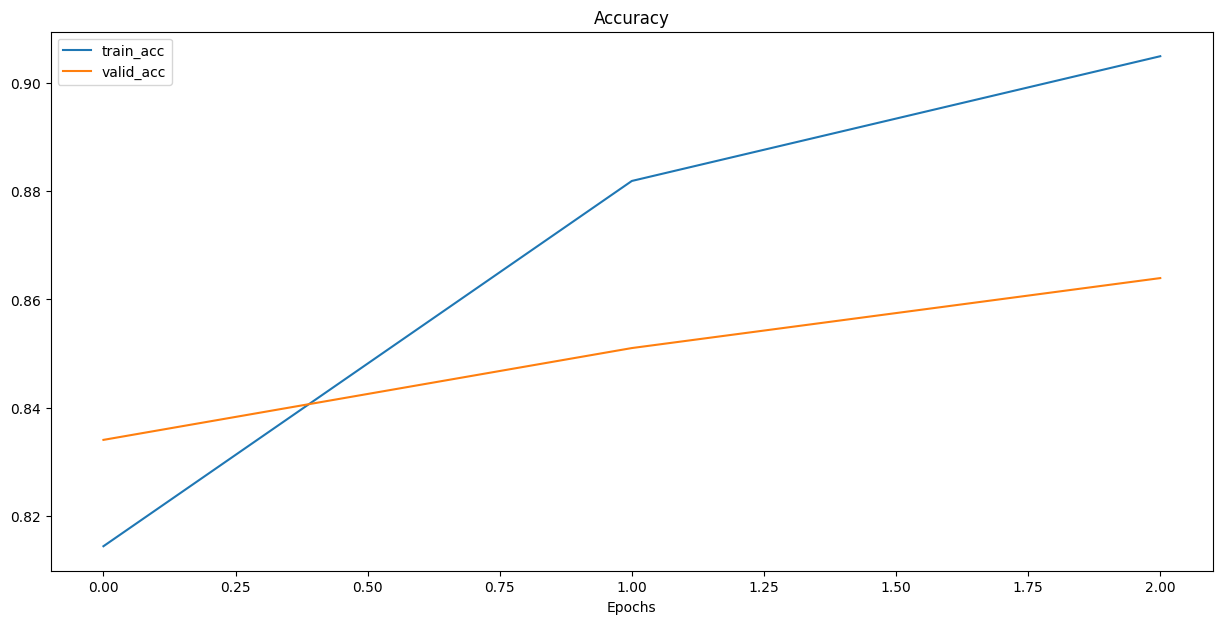

In [10]:
# Plot losses over epochs for training data and test data
plt.figure(figsize=(15, 7))
epochs_range = range(0,num_epochs)
# Plot losses over time
plt.plot(epochs_range, [ acc for acc in  model_results['train_acc'] ], label='train_acc')
plt.plot(epochs_range, [ acc for acc in  model_results['valid_acc'] ], label='valid_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()


In [15]:
size = 512

df_validation = transform_tf_to_df('val', size)
df_train = transform_tf_to_df('train', size)

BATCH_SIZE = 32 if size < 512 else 16
train_data = FlowersDataset(df_train, transform = train_transform)
validation_data = FlowersDataset(df_validation, transform = test_transform)


train_dataloader = DataLoader(train_data, batch_size =BATCH_SIZE, shuffle = True)
validation_dataloader = DataLoader(dataset = validation_data, batch_size = BATCH_SIZE, shuffle = False)

# Calculate final validation accuracy
model.eval()
validation_acc, total_samples = 0, 0
with torch.inference_mode():
    for X, y in validation_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X).argmax(dim =1 )
        validation_acc += (y_pred == y.argmax(dim =1)).sum().item()
        total_samples += len(y)
validation_acc /= total_samples
print(f"Valid Accuracy {round(validation_acc * 100,2)}")

Valid Accuracy 86.4


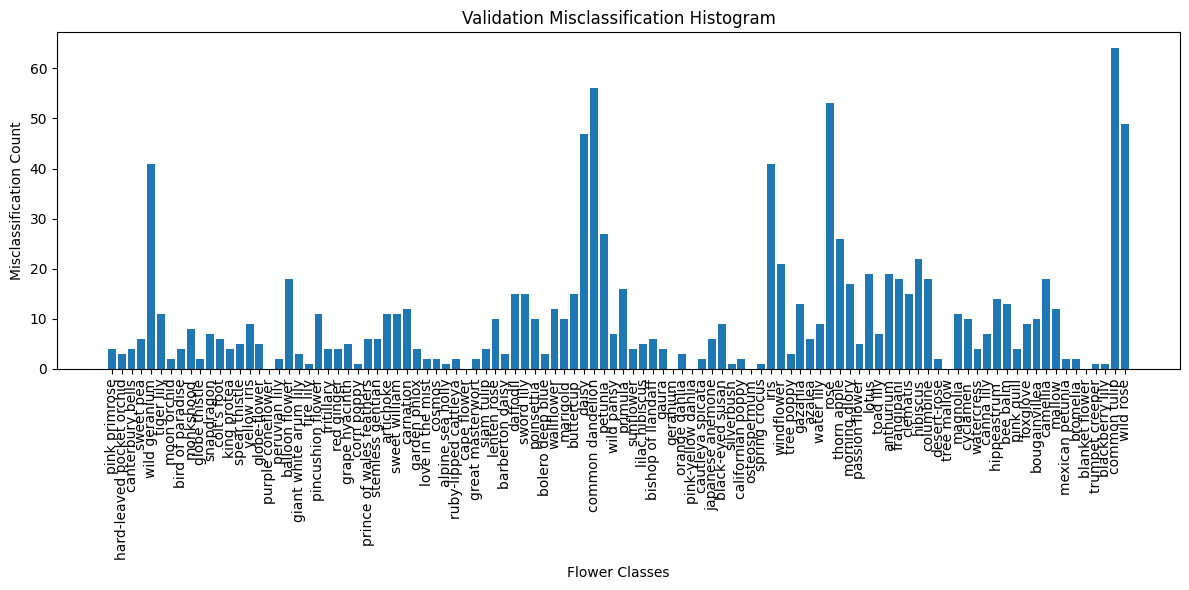

In [12]:
# Calculate make a confusion histogram for validation data
model.eval()
validation_matrix, total_samples = [0] * len(FLOWER_NAMES), 0
with torch.inference_mode():
    for X, y in validation_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X).argmax(dim =1 )

        for y_pred_index, y_index in zip(y_pred, y.argmax(dim =1 )):
            if y_pred_index != y_index: 
                validation_matrix[y_index] +=1 

plt.figure(figsize=(12, 6))
plt.bar(range(len(validation_matrix)), validation_matrix, tick_label=FLOWER_NAMES)
plt.xticks(rotation=90)
plt.title("Validation Misclassification Histogram")
plt.xlabel("Flower Classes")
plt.ylabel("Misclassification Count")
plt.tight_layout()
plt.show()

In [13]:
# Calculate final validation accuracy
model.eval()
validation_acc, total_samples = 0, 0
with torch.inference_mode():
    for X, y in validation_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X).argmax(dim =1 )
        validation_acc += (y_pred == y.argmax(dim =1)).sum().item()
        total_samples += len(y)
validation_acc /= total_samples
print(f"Valid Accuracy {round(validation_acc * 100,2)}")

"""
Experiments done for 224 x 224 image inference

 - Epochs = 10 -> 83.38 % , lR = 0.01 (No weighted + No image transformations)
 - Epochs = 10 -> 83.86 % , lR = 0.01 (No weighted + image transformations (with random rotation) )
 - Epochs = 10 -> 85.37 % , lR = 0.01 (No weighted + image transformations (without random rotation) )
 - Epochs = 10 -> 73.57 % , lR = 0.01 (Using weights for under-represented images + No image transformations )
 - Epochs = 10 -> 80.33 % , lR = 0.001 (Using weights for under-represented images + image transformations )

Experiments done for 512 x 512 image inference
- Epochs = 12ish -> 86.4 %, lr = 0.001 (No weighted + image transformations (without random rotation) )
"""


Valid Accuracy 71.26


'\nExperiments done\n - Epochs = 10 -> 83.38 % , lR = 0.01 (No weighted + No image transformations)\n - Epochs = 10 -> 83.86 % , lR = 0.01 (No weighted + image transformations (with random rotation) )\n - Epochs = 10 -> 85.37 % , lR = 0.01 (No weighted + image transformations (without random rotation) )\n - Epochs = 10 -> 73.57 % , lR = 0.01 (Using weights for under-represented images + No image transformations )\n - Epochs = 10 -> 80.33 % , lR = 0.001 (Using weights for under-represented images + image transformations )\n'

In [14]:
torch.save(model.state_dict(), "epoch_10_noweights.pth")